# CATRA experiments and analysis

## Preliminaries and parsing
In which we read the log files and interpret the data within.

We start out by implementing a crude parser for the log format CATRA outputs. The first step is to define a result: it's a combination of a runtime, a file that the solver was executed on, and a status. If the status is an error, the runtime is undefined.

In [1]:
from collections import namedtuple
from enum import Enum, auto

class Status(Enum):
    SAT = auto()
    UNSAT = auto()
    TIMEOUT = auto()
    MEMORY_OUT = auto()
    ERROR = auto()

Result = namedtuple("Result", ["instance", "status", "runtime"])

Then we define routines for parsing input files:

In [2]:
import re

# This matches anything but an error
LINE_RE = re.compile(
    r"^==== (?P<instance>.*?): (?P<status>sat|unsat|timeout.*ms|memory-out) run: (?P<runtime>.+)s parse: .*====$"
)

# Due to a historical bug in the output format, we allow 3-4 trailing equals signs on errors
ERROR_RE = re.compile("^==== (?P<instance>.*?) error: (?P<message>.*)====?$")

def status_from_str(status):
    if "timeout" in status:
        return Status.TIMEOUT
    if status == "unsat":
        return Status.UNSAT
    if status == "sat":
        return Status.SAT
    if status == "memory-out":
        return Status.MEMORY_OUT
    if "error" in status:
        return Status.ERROR
    
    raise ValueError(f"Unexpected status {status}")
    

def parse_line(line):
    match = LINE_RE.match(line)
    if match:
        status = status_from_str(match.group("status"))
        runtime = (
            float(match.group("runtime"))
            if status not in [Status.TIMEOUT, Status.MEMORY_OUT]
            else float("inf")
        )
        return Result(match.group("instance"), status, runtime)
    match = ERROR_RE.match(line)
    if not match:
        return None
    # It's an error
    return Result(match.group("instance"), Status.ERROR, float("inf"))
    
    
def parse_log(log):
    with open(log) as fp :
        for line in fp:
            result = parse_line(line)
            if result:
                yield result
    

### Common imports

In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

### Constants

In [4]:
backends = ["lazy", "nuxmv", "baseline"]

## Overhead
In order to know how fair our comparison is, we run all solvers repeatedly on the same, trivial instance.

In [5]:
!cat trivial.par

counter int R1;
synchronised {
  automaton value_0 {
    init s0;
    s0 -> s1 [32, 32] { R1 += 1 };
    accepting s1;
  };
};


In [6]:
%%sh
INVOCATIONS=$(perl -E 'say "trivial.par " x 30')

for backend in lazy nuxmv baseline;
do
  ../bin/catra solve-satisfy --backend ${backend} $INVOCATIONS > trivial-${backend}.log
done

In [7]:
df = pd.concat(pd.DataFrame(
    parse_log(f"trivial-{backend}.log"))
          .assign(backend = backend) for backend in backends)

Now we can plot the values to see how they look over time. A clear result is that the first run is much slower for all backends, but less so for nuxmv. This is unsurprising, given that the other backends are running on a cold JVM, while nuxmv does most of the work in a compiled binary. We also see here that once the JVM is warm, the overhead for all back-ends normalise to something very similar, with a small, sub .1-second overhead for cold-starting nuxmv for each instance.

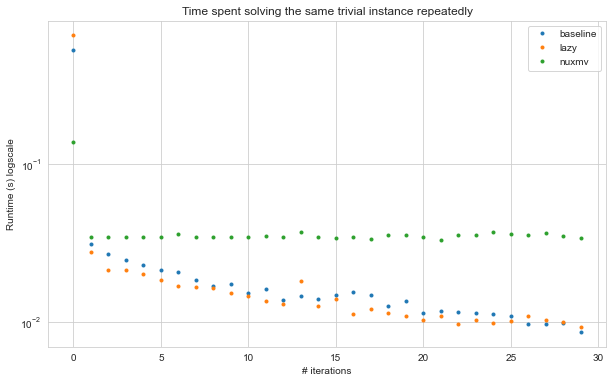

In [8]:
_ = df.groupby("backend")["runtime"].plot(legend=True, 
                                      figsize=(10,6),
                                      xlabel="# iterations", 
                                      ylabel="Runtime (s) logscale",
                                      logy=True,
                                      title="Time spent solving the same trivial instance repeatedly",
                                      style='.')

Filtering out the outliers from the cold runs, we get the following:

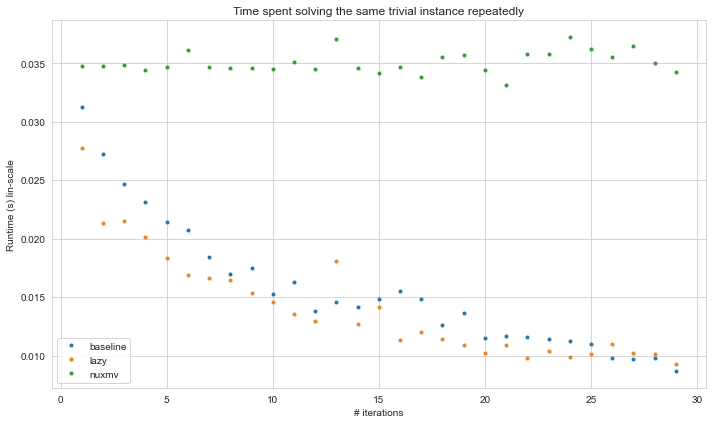

In [36]:
_ = df[df['runtime'] <= 0.1 ].groupby('backend')['runtime'].plot(figsize=(10, 6),
                                      legend=True, 
                                      xlabel="# iterations", 
                                      ylabel="Runtime (s) lin-scale",
                                      style='.',
                                      title="Time spent solving the same trivial instance repeatedly",
                                      logy=False)
plt.tight_layout()

##  Instances solved
How many instances can we solve, in general?

In [10]:
commit = "e8102cf"

How many instances have we executed?

In [11]:
!grep --count '^====.*' ../$commit-*.log

../e8102cf-baseline.log:89
../e8102cf-lazy.log:89
../e8102cf-nuxmv.log:89


First, let's make sure they all agree on the results:

In [12]:
!../bin/compare.py ../$commit-*.log


======= Summary =======
## sat
../e8102cf-nuxmv.log solo win                                       20
../e8102cf-baseline.log/../e8102cf-lazy.log shared timeout loss     20
../e8102cf-baseline.log solo timeout loss                           6
../e8102cf-lazy.log solo win                                        3
../e8102cf-nuxmv.log solo non-timeout loss                          3
../e8102cf-lazy.log/../e8102cf-nuxmv.log shared win                 3

## unsat
../e8102cf-lazy.log solo win                                             27
../e8102cf-baseline.log/../e8102cf-nuxmv.log shared non-timeout loss     11
../e8102cf-baseline.log/../e8102cf-nuxmv.log shared timeout loss         9
../e8102cf-nuxmv.log solo timeout loss                                   6
../e8102cf-baseline.log solo non-timeout loss                            6
../e8102cf-nuxmv.log solo win                                            4
../e8102cf-baseline.log/../e8102cf-lazy.log shared timeout loss          4
../e8102c

In [13]:
runtimes = pd.concat(pd.DataFrame(
    parse_log(f"../{commit}-{backend}.log"))
          .assign(backend = backend) for backend in backends)

In [14]:
runtimes['backend'] = runtimes['backend'].astype("category")
runtimes['status'] = runtimes['status'].astype("category")
runtimes['status'] = runtimes['status'].cat.set_categories(
    [Status.SAT, Status.UNSAT, Status.TIMEOUT, Status.MEMORY_OUT, Status.ERROR], 
    ordered=True)

How many instances are in each category, per backend?

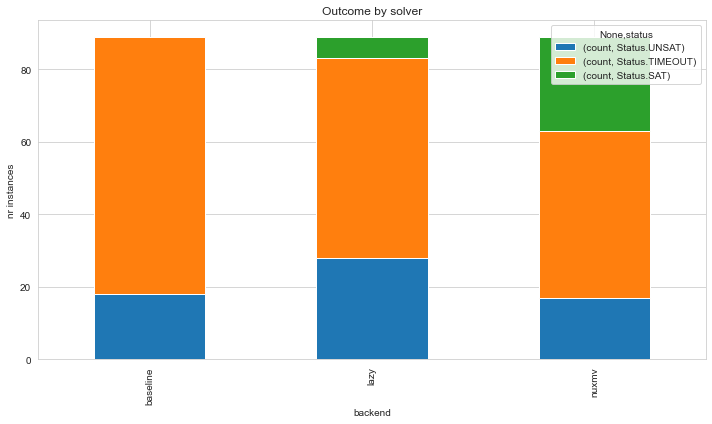

In [37]:
runtime_by_status = runtimes.groupby(['backend', 'status']).size().reset_index()
runtime_by_status = runtime_by_status[runtime_by_status[0] > 0]
runtime_by_status.rename(columns = {0: 'count'}, inplace = True)
runtime_by_status = runtime_by_status.set_index(['backend', 'status'])
runtime_by_status.unstack().plot.bar(figsize=(10,6), 
                                     stacked=True, 
                                     ylabel="nr instances",
                                     title="Outcome by solver")
plt.tight_layout()

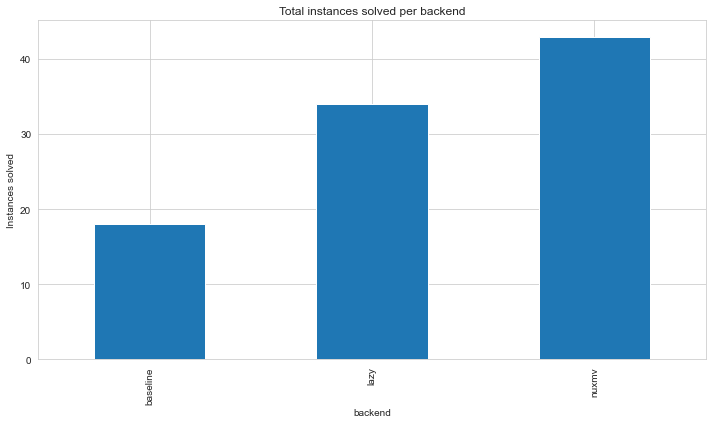

In [39]:
nr_solved = runtimes.groupby(['backend', 'status']).size().reset_index()
nr_solved = nr_solved.loc[nr_solved.status.apply(lambda s: s in [Status.SAT, Status.UNSAT])]
nr_solved.groupby('backend').sum().plot.bar(legend=False,
                                            figsize=(10,6),
                                            ylabel="Instances solved", 
                                            title="Total instances solved per backend")
plt.tight_layout()

How do the respective solvers do on each type of instance?

In [17]:
by_sat_status = pd.concat(group.assign(kind=group.status.min()) 
                          for instance, group in runtimes.groupby('instance'))

by_sat_status['kind'] = by_sat_status['kind'].astype("category")
by_sat_status['kind'] = by_sat_status['kind'].cat.set_categories(
    [Status.SAT, Status.UNSAT, Status.TIMEOUT], 
    ordered=True)

known_solved = by_sat_status[by_sat_status['kind'] != Status.TIMEOUT].copy()
known_solved['kind'] = known_solved['kind'].cat.set_categories(
    [Status.SAT, Status.UNSAT])


In [18]:
pd.pivot_table(known_solved, values=['runtime'], 
               index=['kind', 'status'], columns=['backend'],
               aggfunc='count')['runtime']

backend                         baseline  lazy  nuxmv
kind         status                                  
Status.SAT   Status.SAT                0     6     26
             Status.UNSAT              0     0      0
             Status.TIMEOUT           26    20      0
             Status.MEMORY_OUT         0     0      0
             Status.ERROR              0     0      0
Status.UNSAT Status.SAT                0     0      0
             Status.UNSAT             18    28     17
             Status.TIMEOUT           14     4     15
             Status.MEMORY_OUT         0     0      0
             Status.ERROR              0     0      0

## Execution time
For solved instances, for each backend plot the distribution of runtimes

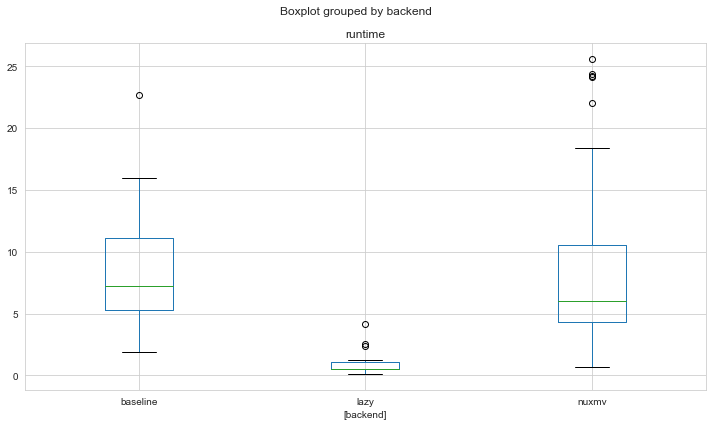

In [45]:
runtimes[runtimes['runtime'] < float('inf')].boxplot(by='backend', figsize=(10,6))
plt.tight_layout()

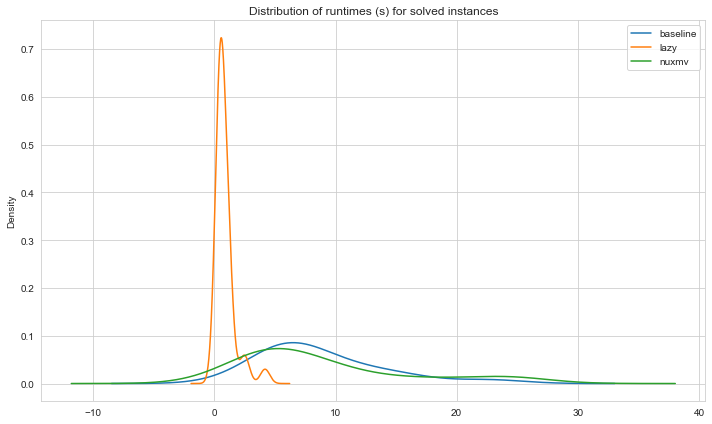

In [51]:
runtimes[runtimes['runtime'] < float('inf')]\
    .set_index('instance')\
    .groupby('backend')\
    .runtime\
    .plot.kde(xlabel='Runtime (s)',
              legend=True,
              figsize=(10, 6),
              title='Distribution of runtimes (s) for solved instances')
plt.tight_layout()

## Scalability (this is the cactus plot section)
If we add more time, how many more instances can we solve?

In [21]:
def solved_after(seconds):
    df = known_solved[known_solved['runtime'] < seconds]\
        .groupby('backend')\
        .size()\
        .reset_index()
    df['after'] = seconds
    df = df.rename(columns = {0: 'nr solved'})
    return df
    
max_seconds = 30
step_size = 0.5

cactus_data = pd.concat([solved_after(i * step_size) for i in range(int(max_seconds / step_size) + 1)], axis=0)

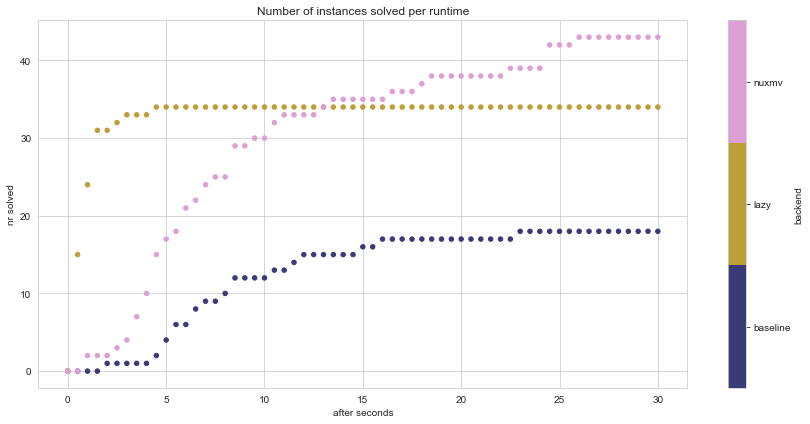

In [47]:
# If we don't use a subplot here, the x ticks and labels all disappear, for no good reason.
fig, ax = plt.subplots()

cactus_data.plot.scatter(x='after', 
                         y='nr solved', 
                         c='backend',
                         xlabel='after seconds',
                         ax=ax,
                         figsize=(12,6),
                         title="Number of instances solved per runtime",
                         cmap=plt.cm.get_cmap('tab20b'))
fig.tight_layout()